###Load librairies:

In [ ]:
from sklearn import datasets
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from random import randint
import random
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


from tensorflow.keras.utils import to_categorical


We load the data:

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8)

#Initializing the population:
At this point, we need to initialize the population. The MLP is known to have activation functions to compute the value of weights, so we took for example the ('identity', 'tanh', 'relu', 'logistic') functions, the same for the optimizers ('sgd', 'adam', 'RMSprop').


The function "*pop_initial_mlp*" will have as an input the size of the population, and return as an output an array which contains an activation function, an optimizer and a size of hidden layers choosen randomly.

In [ ]:
def pop_initial_mlp(mlp):
  pop = []*mlp
  activation_func = ['identity', 'tanh', 'relu', 'logistic']
  optimizer = ['sgd', 'adam']
  for i in range(0, mlp):
    pop.append([random.choice(activation_func), random.choice(optimizer), random.randint(10,100), random.randint(10,100)])
  return pop

test:

In [ ]:
pop = pop_initial_mlp(10)
pop

[['tanh', 'sgd', 100, 68],
 ['tanh', 'sgd', 52, 33],
 ['logistic', 'adam', 66, 45],
 ['tanh', 'adam', 54, 17],
 ['logistic', 'sgd', 96, 43],
 ['relu', 'sgd', 34, 70],
 ['relu', 'sgd', 50, 92],
 ['logistic', 'sgd', 64, 33],
 ['tanh', 'sgd', 53, 19],
 ['identity', 'sgd', 25, 45]]

#Computing fitness value:
The function "*fitness_mlp*" have as input the population gotten with "*pop_initial_mlp*", the train data and the test data, and it returns the value of fitness of each element of the array "*pop*" which represent the attribute of the MLP classifier:

In [ ]:
def fitness_mlp(pop, X_train, y_train, X_test, y_test):
  fitness = []
  mlp = []
  for p in pop:
    mlpc = MLPClassifier(activation=p[0], solver=p[1], hidden_layer_sizes=(int(p[2]),int(p[3])), alpha=0.0001)
    mlp.append([mlpc,p])
  for m in mlp:
      m[0].fit(X_train, y_train)
      acc = accuracy_score(m[0].predict(X_test), y_test)
      fitness.append([acc, m[0], m[1]])
  return fitness

test:

In [ ]:
fitness = fitness_mlp(pop, X_train, y_train, X_test, y_test)
#for fit in fitness:
#  print("*****************************")
#  print(fit[0])
#  print(fit[1])
#  print(fit[2])
#  print("*****************************")

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#Select chromosomes with Rank Selection:
The function bellow select chromosomes based on the fitness ranking, so the chromosomes which have the better fitness as best parents and the ones with a low fitness as worst parents:


In [ ]:
def pop_fitness_selection(fitness):
  fittest= sorted(fitness, key=lambda elt: elt[0])
  fittest.reverse()
  fittest = np.array(list(fittest))
  best_parent = fittest[:,2][:len(fittest)//2]
  worst_parent = fittest[:,2][len(fittest)//2:]
  return best_parent, worst_parent, fittest

test:

In [ ]:
best_parent, worst_parent, fitness_sorted = pop_fitness_selection(fitness)
#for fit in fittest:
#  print(fit[0])
#  print(fit[2])
#print("************************")
#print("parents")
print("***")
print(best_parent[0])
print("***")
print(worst_parent[1])

***
['tanh', 'adam', 54, 59]
***
['relu', 'sgd', 34, 79]


#Crossover:
At this part we will crossover the best and worst parent to get better children (eugenics ~ eugénisme), so the child will get the chromosomes of the parents:

In [ ]:
def crossover_mlp(best_parent, worst_parent):
  child = [best_parent[0], worst_parent[1], best_parent[2], worst_parent[3]]
  return child

test:

In [ ]:
child = crossover_mlp(best_parent, worst_parent)
child

[['tanh', 'adam', 54, 59],
 ['relu', 'sgd', 34, 79],
 ['identity', 'sgd', 25, 29],
 ['logistic', 'sgd', 64, 70]]

#Mutation (Random Resetting):
Like viruses and living species, choromosomes mutates to adapt to new environments. At this point, we mutate the chromosome of the best parents and worst parents with a probabilistic threshold, the mutation will be random, as we'll change the size of the MLP randomly:

In [ ]:
def mutation_mlp(child, prob):
  for l in range(0,len(child)):
    if np.random.rand() > prob:
      child[l][randint(2,3)] = child[l][randint(2,3)]+randint(1,10)
  return child

In [ ]:
child = mutation_mlp(child, 0.2)
child

[['tanh', 'adam', 54, 59],
 ['relu', 'sgd', 34, 79],
 ['identity', 'sgd', 25, 27],
 ['logistic', 'sgd', 64, 69]]

#Genetic Algorithm:
At this part we'll just apply the genetic algorithm, using the methodes defined previously.
First, we'll initialize a population "*pop*" which is an mlp of size "*mlp*", compute it "*fitness*" then choose the best and worst parents (those who've a great fitness and the ones with the worst fitness).
Secondly, we'd try to get the "*best_childs*" by calculating the fitness of two childrens, the "*firstchild*" we'll be the result of a crossover between the "*best_parent*" and the "*worst_parent*" that we'd get by calculating the firness of the population "*pop*", and the "*secondchild*" will be mutated randomly by the threshold "*prop*", and keep looping on the number of "*epochs*" to get better results.

In [ ]:
def ga_mlp(X_train, y_train, X_test, y_test, epochs, mlp, prob):
  pop = pop_initial_mlp(mlp)
  fitness = fitness_mlp(pop, X_train, y_train, X_test, y_test)
  best_parent, worst_parent, fittest = pop_fitness_selection(fitness)

  for e in range(0, epochs):
    for i in range(0, len(best_parent)):
      firstchild = [crossover_mlp(best_parent[i], worst_parent[i])]
      secondchild = [crossover_mlp(worst_parent[i], best_parent[i])]
    secondchild = mutation_mlp(secondchild, prob)

    fitness_firstchild = fitness_mlp(firstchild, X_train, y_train, X_test, y_test)
    fitness_secondchild = fitness_mlp(secondchild, X_train, y_train, X_test, y_test)
    fitness_childs = np.concatenate((fittest, fitness_firstchild, fitness_secondchild))
    best_childs, worst_child, fittest_child = pop_fitness_selection(fitness_childs)

    fitness = fittest_child[0:mlp, :]
    best_child = fittest_child[0][1]
  return best_child

#Application de l'algorithme génétique sur le MLP:

#### Meilleur chromosome:
The execution of the function "*ga_mlp*" returns the best choromosome which is "*best_child*":

In [ ]:
best_child = ga_mlp(X_train, y_train, X_test, y_test, epochs= 1, mlp= 5, prob= 0.8)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
best_child

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 56), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### Accuracy:
the accuracy is the rate of the test labels which were correctly detected divised by all the test labels:

In [ ]:
accuracy = accuracy_score(best_child.predict(X_test),y_test)
accuracy

0.95

In [ ]:
best_child.predict(X_test)

array([2, 1, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 2, 2, 2, 0, 2, 1, 2,
       1, 0, 0, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1,
       2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 0,
       0, 2, 1, 2, 0, 2, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 1, 1, 0, 1,
       0, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 1, 1, 0])

In [ ]:
y_test

array([1, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 0, 1, 1, 1, 0, 0, 0,
       2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2,
       0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 1,
       2, 2, 2, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

####Confusion Matrix:
Confusion matrix is a matrix which describe the numbers of each predicted labels against the true values.

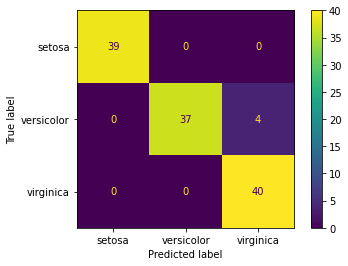

In [ ]:
o = ['setosa', 'versicolor', 'virginica']
cm = confusion_matrix(y_test, best_child.predict(X_test))
ConfusionMatrixDisplay(cm, o).plot()

#### Roc:
The ROC curve make us have an idea of how good is the prediction of our model.
we'll use the function "*roc_curve*" which has as input the true binary labels and predicted binary labels.
the function returns the "*fpr*" dictionary which is the false positive rates and "*tpr*" true positive rates.
The curve represent the confusion matrix with differents thresholds.
So the curve shows that we have a performent model with a true positive rate close to 1 and false positive rate close to 0.

In [ ]:
pred = np.array(best_child.predict(X_test))
y_test = to_categorical(y_test)
pred = to_categorical(pred)

n_classes=len(y_test[0])
lw=2

Text(0.5, 1.0, 'ROC curve')

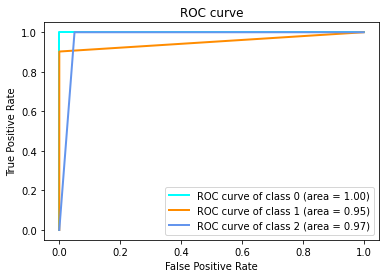

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], pred[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC curve")

####Precision recall:

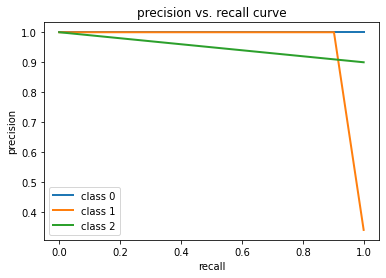

In [ ]:
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()